# Hierarchical Approaches

When we face problems with a very big complexity like doing routing over a graph of continent with millions of nodes, surely we won't do Dijkstra or Depth First Search. We resort to do pruning of the search space and some precomputations that we can always have stored on our servers, so when the user's query arrives we are ready for it.

## Highway Hierarchies

It was described at [Highway Hierarchies Hasten Exact Shortest Path Queries - ESA 2005](https://link.springer.com/chapter/10.1007/11561071_51).  
We compute hierarchy level for each **arc**/ways of the graph to distinguish residential roads and national roads and highways and some other heuristics the affect the level of the arc like the max speed/# of turns. After the precomputation we run bi-directional Dijkstra/(or any type) and as we run the algorithm we consider the level of the arcs like if we are very far away from our destination we only consider highways and if we are closer we look at national roads and if we are really close we traverse residential roads.  
That is the pruning we said at the beginning, and the algorithm makes sense because if you are living at the side of the highway and want to go some place close to your place, you won't take the highway and would prefer going through resdential roads, despite the fact that the highway is *faster*.  

---

## Contraction Hierarchies

As you saw that the highway hierarchies algorithm gives us back 3 level/hierarchies (residential roads/ national roads/ highways) and that is how it prunes the search space. Contraction hierarchies introduced at [Contraction Hierarchies: Faster and Simpler Hierarchical Routing in Road Networks](https://link.springer.com/chapter/10.1007/978-3-540-68552-4_24) gives us more levels of hierarchies for each node based on when the node was *contracted*, so number of levels are equal to the number of nodes (will be explained later).

We won't get into the correctness proof of the algorithm, for that check the paper. If you are familiar with correctness proof of graph algorithms, you will find it super straightforward.  

### Contraction

Take a node out from the graph and its adjacent edges and add new edges to the graph to keep the shortest path between all pairs of nodes in the graph preserved as if the node was still in the graph, that will produce another graph without the deleted node and its adjacent edges and with the new added arces so you take another node out and its adjacent edges and add the necessary arcs. You keep going untill you contracted all nodes.

The new graph that would be used in the algorithm is the original graph with all the arcs that were added to keep the shortest path invariant through the process of contraction.

We compute the level of a node as its order of contraction, so the available levels are equal to the number of nodes in the graph; from 1 to n.

#### What order of contraction to the nodes should I follow?

Any order will make the algorithm runs successfuly, but some orders will shorten the time of contraction and minimizes the number of arcs addes to the graph. 

We will see one in the implementation below.

### Bi-directional Dijkstra

So after contraction we have a graph with nodes labeled with some level. We do dijkstra from the source and dijkstra from the destination.  

The point of these two dijkstra is not about finding the destination, but to find the shortest path between the source and all the other nodes in the graph.  

But we have a restriction over the dijkstra from the source and the dijkstra from the destionation.  

* The dijkstra from the source only considers arcs _u_, _v_ where level(_u_) > level(_v_) so you only want to relax node with a higher level than the node you have relaxed at that iteration. This is called the **upward graph**.  

* The dijkstra from the destination only considers arcs _u_, _v_ where level(_u_) < level(_v_) so you only want to relax node with a lower level than the node you have relaxed at that iteration. This is called the **downward graph**

That is the pruning we talked about.  

At the end you see the common nodes that have been relaxed from both graphs and connect them and return the minimum path.

In [1]:
import networkx as nx
import random
import math

In [2]:
G = nx.Graph()

When you do contraction to compute the levels of the node, you need to produce new graph every time to do the next contraction. But that would be a lot of memory so you would just have a flag on every node that eliminates that node and its adjacent edges from the graph.

In [3]:
G.add_node(1,contracted=False)
G.add_node(2,contracted=False)
G.add_node(3,contracted=False)
G.add_node(4,contracted=False)
G.add_node(5,contracted=False)
G.add_node(6,contracted=False)
G.add_node(7,contracted=False)
G.add_node(8,contracted=False)
G.add_node(9,contracted=False)
G.add_node(10,contracted=False)
G.add_node(11,contracted=False)
G.add_node(12,contracted=False)
G.add_node(13,contracted=False)
G.add_node(14,contracted=False)

In [4]:
edges = [
    (1,2,{'weight':1}),
    (1,3,{'weight':4}),
    (1,7,{'weight':7}),
    (2,3,{'weight':5}),
    (2,4,{'weight':2}),
    (3,4,{'weight':2}),
    (3,6,{'weight':1}),
    (3,7,{'weight':2}),
    (3,8,{'weight':1}),
    (3,9,{'weight':1}),
    (4,5,{'weight':5}),
    (5,10,{'weight':7}),
    (6,7,{'weight':4}),
    (6,8,{'weight':3}),
    (6,10,{'weight':3}),
    (6,5,{'weight':3}),
    (6,9,{'weight':1}),
    (7,8,{'weight':6}),
    (8,9,{'weight':3}),
    (8,13,{'weight':5}),
    (9,12,{'weight':1}),
    (9,10,{'weight':3}),
    (10,11,{'weight':4}),
    (11,12,{'weight':3}),
    (11,13,{'weight':4}),
    (12,13,{'weight':2}),
    (14,1,{'weight':3}),
    (14,13,{'weight':2})
]

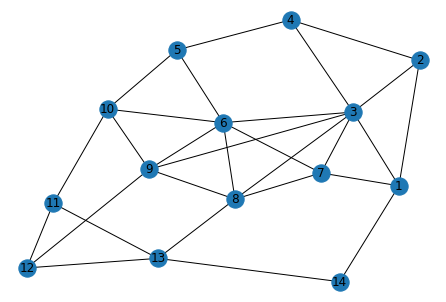

In [5]:
G.add_edges_from([*edges])
nx.draw(G,with_labels=True)

In [6]:
def dijkstra_with_contraction(G, source, destination, contracted = None):
    nx.set_node_attributes(G, {contracted: True}, 'contracted')
        
    shortest_path = dict()
    heap = list()
    
    for i in G.nodes():
        if not nx.get_node_attributes(G, 'contracted')[i]:
            shortest_path[i] = math.inf
            heap.append(i)
    shortest_path[source] = 0
    
    while len(heap) > 0:
        q = min(heap, key = lambda node : shortest_path[node])
        if q == destination:
            nx.set_node_attributes(G, {contracted: False}, 'contracted')
            return shortest_path[q]
        heap.remove(q)
        for v in G[q]:
            if not nx.get_node_attributes(G, 'contracted')[v]:
                distance = shortest_path[q] + G[q][v]['weight']
                if distance < shortest_path[v]:
                    shortest_path[v] = distance
    nx.set_node_attributes(G, {contracted: False}, 'contracted')
    return math.inf

In [7]:
shortest_paths = dict()
for i in G.nodes():
    shortest_paths[i] = dict()
    for j in G.nodes():
        shortest_paths[i][j] = dijkstra_with_contraction(G, i, j)

In [8]:
def calculate_edge_difference(G, shortest_paths):
    edge_difference = list()
    seenBefore = list()
    for i in G.nodes():
        edges_incident = len(G[i])

        contracted_node_paths = shortest_paths[i]
        del shortest_paths[i]

        new_graph = [*G.nodes()] # excluding the node that we have just contracted
        new_graph.remove(i)

        new_shortest_paths = dict()

        for source in new_graph:
            new_shortest_paths[source] = dict()
            for destination in new_graph:
                new_shortest_paths[source][destination] = dijkstra_with_contraction(G, \
                                                                                    source, \
                                                                                    destination, \
                                                                                    contracted = i)
        shortcuts = 0

        for source in new_shortest_paths:
            SP_contracted = new_shortest_paths[source]
            SP_original = shortest_paths[source]
            for destination in SP_contracted:
                if [source, destination] in seenBefore: continue
                seenBefore.append(sorted((source,destination)))
                if SP_contracted[destination] != SP_original[destination]:
                    shortcuts += 1

        shortest_paths[i] = contracted_node_paths

        ED = shortcuts - edges_incident
        edge_difference.append((i, ED))
    return edge_difference

In [9]:
edge_difference = calculate_edge_difference(G, shortest_paths)

In [10]:
edge_difference.sort(key = lambda pair : pair[1])
edge_difference

[(8, -5),
 (7, -4),
 (10, -4),
 (5, -3),
 (11, -3),
 (2, 0),
 (14, 0),
 (1, 2),
 (6, 3),
 (13, 5),
 (4, 6),
 (12, 18),
 (9, 22),
 (3, 29)]

In [11]:
G.edges()

EdgeView([(1, 2), (1, 3), (1, 7), (1, 14), (2, 3), (2, 4), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (5, 10), (5, 6), (6, 7), (6, 8), (6, 10), (6, 9), (7, 8), (8, 9), (8, 13), (9, 12), (9, 10), (10, 11), (11, 12), (11, 13), (12, 13), (13, 14)])

In [12]:
current_graph = [*G.nodes()]

for node_ED in edge_difference:
    node = node_ED[0]
    nx.set_node_attributes(G, {node: True}, 'contracted')
    
    # we have already contracted the node
    # so there is no need 
    new_graph = current_graph
    new_graph.remove(node)
    current_shortest_paths = dict()
    for source in new_graph:
            current_shortest_paths[source] = dict()
            for destination in new_graph:
                current_shortest_paths[source][destination] = dijkstra_with_contraction(G, \
                                                                                    source, \
                                                                                    destination)
    # edge ordering heurisitc works ver
    for source in current_shortest_paths:
        SP_contracted = current_shortest_paths[source]
        SP_original = shortest_paths[source]
        for destination in SP_contracted:
            if source == destination: continue
            if SP_contracted[destination] != SP_original[destination]:
                # adding edge from 1 to 2 OR from 2 to 1 is the same thing in networkx
                # so we don't need to overcomplicate our code to handle repetitive edges
                # networkx does it on its own
                print(source, destination, node, SP_original[destination], SP_contracted[destination])
                G.add_edge(source, destination, weight=SP_original[destination])
                
    
    current_graph = new_graph

1 4 2 3 6
4 1 2 3 6
4 14 2 6 8
14 4 2 6 8
1 13 14 5 8
13 1 14 5 8


In [13]:
# adding edge from 1 to 2 OR 2 to 1 is the same thing
G.edges()

EdgeView([(1, 2), (1, 3), (1, 7), (1, 14), (1, 4), (1, 13), (2, 3), (2, 4), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 14), (5, 10), (5, 6), (6, 7), (6, 8), (6, 10), (6, 9), (7, 8), (8, 9), (8, 13), (9, 12), (9, 10), (10, 11), (11, 12), (11, 13), (12, 13), (13, 14)])

In [14]:
hierarchical_order = dict()
for order, node in enumerate(edge_difference):
    hierarchical_order[node[0]] = order

In [15]:
hierarchical_order

{8: 0,
 7: 1,
 10: 2,
 5: 3,
 11: 4,
 2: 5,
 14: 6,
 1: 7,
 6: 8,
 13: 9,
 4: 10,
 12: 11,
 9: 12,
 3: 13}

source is 8 and target is 12

# Dijkstra From Source

In [16]:
dist_s = dict()
heap_s = list()
for i in G.nodes():
    dist_s[i] = math.inf
    heap_s.append(i)
dist_s[10] = 0

# we will need this flag to know when
# to stop the search if we got stuck
# because of hierarchical ordering

stuck = False

while not stuck:
    stuck = True
    min_node = min(heap_s, key = lambda node : dist_s[node])
    heap_s.remove(min_node)
    order_parent = hierarchical_order[min_node]
    for child in G[min_node]:
        order_child = hierarchical_order[child]
        # from source we need the order of the child
        # to be bigger than the order of the parent
        # to relax that edge
        if order_child < order_parent: continue
        stuck = False
        distance = dist_s[min_node] + G[min_node][child]['weight']
        if distance < dist_s[child]:
            dist_s[child] = distance
        
        

In [17]:
dist_s

{1: inf,
 2: inf,
 3: 4,
 4: inf,
 5: 7,
 6: 3,
 7: inf,
 8: inf,
 9: 3,
 10: 0,
 11: 4,
 12: inf,
 13: inf,
 14: inf}

# Dijkstra From Target

In [18]:
dist_f = dict()
heap_f = list()
for i in G.nodes():
    dist_f[i] = math.inf
    heap_f.append(i)
dist_f[12] = 0


stuck = False

while not stuck:
    stuck = True
    min_node = min(heap_f, key = lambda node : dist_f[node])
    heap_f.remove(min_node)
    order_parent = hierarchical_order[min_node]
    for child in G[min_node]:
        order_child = hierarchical_order[child]
        # from source we need the order of the child
        # to be bigger than the order of the parent
        # to relax that edge
        if order_child < order_parent: continue
        stuck = False
        distance = dist_f[min_node] + G[min_node][child]['weight']
        if distance < dist_f[child]:
            dist_f[child] = distance

In [19]:
dist_f

{1: inf,
 2: inf,
 3: 2,
 4: inf,
 5: inf,
 6: inf,
 7: inf,
 8: inf,
 9: 1,
 10: inf,
 11: inf,
 12: 0,
 13: inf,
 14: inf}

We need to merge the common settled nodes from both `dist_f` and `dist_s` and see that shortest path and that is our shortest path

In [20]:
minimum = math.inf
merge_node = None
for i in dist_s:
    if dist_f[i] == math.inf: continue
    if dist_f[i] + dist_s[i] < minimum:
        minimum = dist_f[i] + dist_s[i]
        merge_node = i

In [21]:
minimum

4

let's use networkx algorithm to see if that is true or not 

In [22]:
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra

In [23]:
single_source_dijkstra(G,10,12)

(4, [10, 9, 12])

voila